# Helicopter Optimal Control Under Wind: Disturbance Observer Based Method

#### Disturbance Observer-based method for wind-disturbance compensation has been implemented here, on X-CELL 60 SE Helicopter. This setup can be said to lie inside the framework of LQR/LQG. The wind has been modeled as a random walk process, that is estimated using Kalman Filter algorithm and fed-back to the control inputs with the intention of pre-compensating for predicted/estimated wind disturbance at the next step.

#### The choice of wind-velocities for Linearization turns out to determine the "degree" of extra compensation on top of Vanilla LQR(i.e. without any estimation): Degree of compensation provided by DOb over Vanilla LQR is proportional to how far off of [0; 0; 0] m/s (Wind Disturbance), the linearization point was chosen.


When ground-truth wind matches Linearization Point’s wind velocity, Dob provides little to no improvement over Vanilla LQR controller.

#### This is because the choice of wind-vector for linearization directly affects the terms within the K matrix that map the observed disturbance back onto the control inputs. Experiments conducted in this simulation show that there is a need to update Linearization online as the wind changes to provide better robustness against wind!

The DOb architecture does not provide added advantage over Vanilla-LQR when the Linearization was done around, for instance, [-4, -4, 2] m/s of wind-velocity, and the actual wind (I made it not deviate too much from this value) was on the other side of zero, i.e., [4,4,1] m/s. (The Vanilla-LQR went with the wind. The DOb-LQR went on the opposite side of the setpoint and gave steady-state error, there.)


 Actuaton in Body-Frame Y-direction is contibuted by two actuators: Tail Rotor & Main Rotor tilt. This is evident in this graph, where more disturbance compensation is observed in Y-direction than in X. 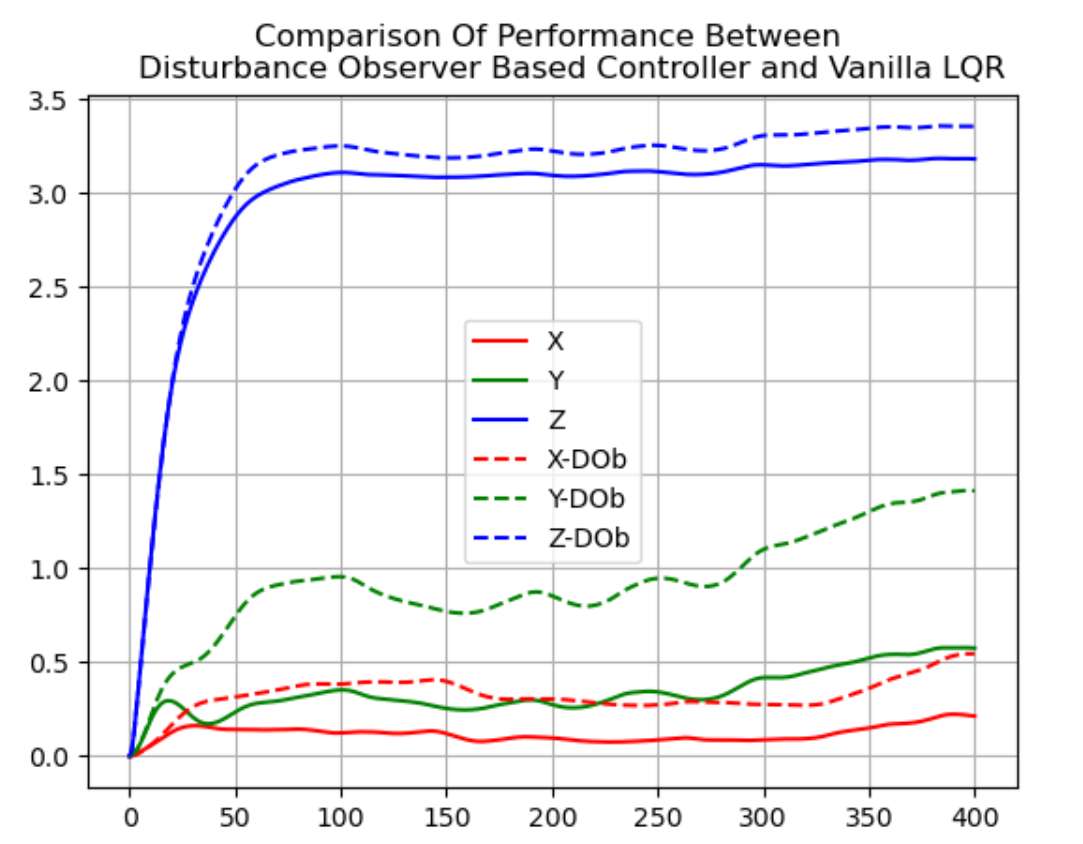

Looking from the top, the tail rotor exerts a force on the left. Wind towards the left blows the heli farther away from straight line (LQR case) than wind blowing to the right for the same wind force...

## Importing Packages:

In [143]:
import Pkg;
Pkg.add("Plots")
Pkg.add("PyPlot")
using Plots
using PyPlot

   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`


In [144]:

Pkg.add("StaticArrays")
Pkg.add("GeometryBasics")
Pkg.add("Colors")

   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`


In [145]:
Pkg.activate(@__DIR__); Pkg.instantiate()
Pkg.add("BlockDiagonals")
Pkg.add("OSQP")
Pkg.add("ControlSystems")
Pkg.add("Quaternions")
Pkg.add("TrajOptPlots")
Pkg.add("CoordinateTransformations")
Pkg.add("Rotations")
using LinearAlgebra
using ForwardDiff
using BlockDiagonals
using ControlSystems
using RobotDynamics
using Plots
using TrajOptPlots
using StaticArrays
using SparseArrays
using Printf
using Test
using MeshCat
using GeometryBasics
using Colors
using CoordinateTransformations, Rotations, StaticArrays
using Quaternions
using OSQP

  Activating project at `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\

## Function Definitions:

### Quaternions>>

In [146]:
# Quaternion
# Hat for Cross Product
function hat(v)
    return [0 -v[3] v[2]; v[3] 0 -v[1]; -v[2] v[1] 0]
end

# Left Multiplier of Quaternion
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s -v'; v (s * I + hat(v))]
    return L
end

T = Diagonal([1; -ones(3)])

H = [zeros(1,3); I]

# Quaternion to Rotation
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end

# Attitude Jacobian
function G(q)
    G = L(q) * H
end

# Rodrigues Parameter Represntation to Quaternion
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end

# Cayley Map (Quaternion to Rodrigues Parameters)
function qtorp(q)
    q[2:4]/q[1]
end

# Euler Angles to Quaternion
function eultoq(ϕ)
    cr = cos(0.5 * ϕ[1])
    sr = sin(0.5 * ϕ[1])
    cp = cos(0.5 * ϕ[2])
    sp = sin(0.5 * ϕ[2])
    cy = cos(0.5 * ϕ[3])
    sy = sin(0.5 * ϕ[3])
    
    qw = (cr * cp * cy) + (sr * sp * sy)
    qx = (sr * cp * cy) - (cr * sp * sy)
    qy = (cr * sp * cy) + (sr * cp * sy)
    qz = (cr * cp * sy) - (sr * sp * cy)
    return [qw; qx; qy; qz]
end

# Quaternion to Euler Angles
function qtoeul(q)
    roll = atan(2*(q[1]*q[2] + q[3]*q[4]), 1-2*(q[2]*q[2] + q[3]*q[3]))
    pitch = asin(2*(q[1]*q[3] - q[4]*q[2]))
    yaw = atan(2*(q[1]*q[4] + q[2]*q[3]), 1-2*(q[3]*q[3] + q[4]*q[4]))
    return [roll; pitch; yaw]
end 

## For Wind Vector Visualizer:
function wind_quat(X,t)
    W = zeros(3,1)
    q_wind = zeros(4,1)
    W .= X[13:15,t]
    phi = acos(W[1]/(norm(W)))
    theta = acos(W[2]/(norm(W)))
    psi = acos(W[3]/(norm(W)))
    angles = [phi;theta;psi]
    q_wind .=  eultoq(angles)
    return q_wind
end




wind_quat (generic function with 2 methods)

### X-Cell 60 Heli Parameters>>

In [147]:
# Helicopter Parameters
# Mass
M = 8.2 #kg

# Inertia
Ixx = 0.18 #kg m^2
Iyy = 0.34 #kg m^2
Izz = 0.28 #kg m^2
J = Diagonal([Ixx, Iyy, Izz])

# Main Rotor
hmr = 0.235 #m
Ωmr = 167 #rad/s
Rmr = 0.775 #m

# Drag Parameters
# https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
Cd = 1.17 #square flat plate 90degrees to the wind.
Sx_fus = 0.1 #m^2
Sy_fus = 0.22 #m^2
Sz_fus = 0.15 #m^2

# Tail Rotor
ntr = 4.66 #Gear ratio of tr to mr
Ωtr = ntr * Ωmr #rad/s
Rtr = 0.13 #m
ltr = 0.91 #m
htr = 0.08 #m

# Physical Parameters
g = 9.81 #m/s^2
ρ = 1.204 #kg/m^3

1.204

### Animation>>

In [148]:
# Animation
function set_heli_model!(vis::Visualizer) #(vis::Visualizer)
    #### Note: all dimensions in metres.
    width = 0.05
    # Length:
    Ltr = 0.91
    
    # Tail Rotor:
    htr = 0.08
    Rtr = 0.13
    
    # Main Rotor
    hmr = 0.235
    Rmr = 0.775
    
    # Fuselage:
    rad_fuse = 0.20
    Rshaft = 0.01

    fuselage = Sphere(Point3(0,0.0,0.0),rad_fuse)
    #fuselage2 = Sphere(Point3(-0.15,0.0,0.0),rad_fuse)
    MainRotor = Cylinder(Point3(0.0,0.0,hmr), Point3(0.0,0.0,hmr + 0.01), Rmr)
    Rotorshaft = Cylinder(Point3(0.0,0.0,0.0), Point3(0.0,0.0,hmr), Rshaft)
    Chassis = Rect3D(Vec(-Ltr,-width/2,-width/2), Vec(Ltr,width,width)) #body diagonal of a cuboid ??
    TailRotor = Cylinder(Point3(-Ltr,-0.04,htr), Point3(-Ltr,0.04,htr), Rtr)
    
    #For wind vector represetation:
    #Wind = Cylinder(Point3(hmr*4,0.0,0), Point3(0.0,0.0,0.0), Rmr/10)
    

    setobject!(vis["geom"]["fuselage"], fuselage, MeshPhongMaterial(color=colorant"gray"))
    #setobject!(vis["geom"]["fuselage2"], fuselage2, MeshPhongMaterial(color=colorant"gray"))
    setobject!(vis["geom"]["MainRotor"], MainRotor, MeshPhongMaterial(color=colorant"black"))
    setobject!(vis["geom"]["Rotorshaft"], Rotorshaft, MeshPhongMaterial(color=colorant"gray"))
    setobject!(vis["geom"]["Chassis"], Chassis, MeshPhongMaterial(color=colorant"blue"))
    setobject!(vis["geom"]["TailRotor"], TailRotor, MeshPhongMaterial(color=colorant"black"))
    
    #For wind vector represetation:
    #setobject!(vis["geom"]["Wind"], Wind, MeshPhongMaterial(color=colorant"red"))
    
    return Nothing
end
#animate(vis, X, T, h)
function animate(vis, X, T, h)
    anim = MeshCat.Animation(Int(1/h))
    q_wind = zeros(4,1)
    for t=1:size(thist,1) #10000
        atframe(anim, t) do
            #trans = Translation(10.0,0.0,0.0)
            trans = Translation(X[1,t],X[2,t],X[3,t])
            Q = qtoQ(X[4:7,t])
            rot = LinearMap(qtoQ([0.0,1.0,0.0,0.0]) * Q)
            

            
            
            ##############################
            trans2 = Translation(X[1,5],X[2,5],X[3,5])
            #settransform!(vis2, trans2 ∘ rot)
            #settransform!(vis["geom"]["fuselage"]], trans2 ∘ rot)
            ##############################
            
            #settransform!(vis, trans ∘ rot)
            settransform!(vis["geom"]["fuselage"], trans ∘ rot)
            settransform!(vis["geom"]["MainRotor"], trans ∘ rot)
            settransform!(vis["geom"]["Rotorshaft"], trans ∘ rot)
            settransform!(vis["geom"]["Chassis"], trans ∘ rot)
            settransform!(vis["geom"]["TailRotor"], trans ∘ rot)
            
            #### For wind vector represetation>>
            #q_wind .= wind_quat(X,t)
            #Q_wind = qtoQ(q_wind)
            #rot2 = LinearMap(qtoQ([0.0,1.0,0.0,0.0]) * Q_wind)
            #rot2 = LinearMap(Q_wind)
            #settransform!(vis["geom"]["Wind"], trans ∘ rot2)
            #### For wind vector represetation<<
            
        end
    end
    return anim
end

animate (generic function with 1 method)

### Plot Comparison>>

In [149]:
function comparison_plot(Z...)
    p = plot(layout=(2,2), size=(900,600))
    for z in Z
        plot!(p[1], z[3], z[1][1:end,1], label=z[4]*" x", 
            xlabel="Time (s)", ylabel="Position (m)", legend=:topright)
        plot!(p[1], z[3], z[1][1:end,2], label=z[4]*" y")
        plot!(p[1], z[3], z[1][1:end,3], label=z[4]*" z")
        
        plot!(p[2], z[3], z[1][1:end,8], label=z[4]*" u", 
            xlabel="Time (s)", ylabel="Linear Velocity (m/s)", legend=:topright)
        plot!(p[2], z[3], z[1][1:end,9], label=z[4]*" v")
        plot!(p[2], z[3], z[1][1:end,10], label=z[4]*" w")
        
        plot!(p[3], z[3], z[1][1:end,11], label=z[4]*" p", 
            xlabel="Time (s)", ylabel="Angular Velocity (rad/s)", legend=:topright)
        plot!(p[3], z[3], z[1][1:end,12], label=z[4]*" q")
        plot!(p[3], z[3], z[1][1:end,13], label=z[4]*" r")
        
        plot!(p[4], z[3][1:end-1], z[2][1:end,1], label=z[4]*" u1", 
            xlabel="Time (s)", ylabel="Control Inputs", legend=:topright)
        plot!(p[4], z[3][1:end-1], z[2][1:end,2], label=z[4]*" u2")
        plot!(p[4], z[3][1:end-1], z[2][1:end,3], label=z[4]*" u3")
        plot!(p[4], z[3][1:end-1], z[2][1:end,4], label=z[4]*" u4")
    end
    p
end



comparison_plot (generic function with 1 method)

### Simulation Parameters>>

In [150]:
# Simulation Parameters
h = 0.05    # Time step

Nx = 19      # Number of States (Quaternion)
Nx̃ = 18      # Number of States (Linearized)
Nu = 4       # Number of Controls

n = Nx
m = Nu

Tfinal = 20.0                                 # Final Time
Nt = Int(Tfinal/h)+1                         # Number of Time steps
thist = Array(range(0, h*(Nt-1), step = h));  

### Helicopter Dynamics>>

In [151]:
# Helicopter Dynamics
function helicopter_dynamics(x, u)
    # x: [x y z Quat u v w p q r wx wy wz]'
    # u: [a b Tmr Ttr]'
    
    r = x[1:3] #x y z
    q = x[4:7]
    v = x[8:10] #u v w
    ω = x[11:13] #p q r
    w = x[14:16]
    vw = x[17:19]
    Q = qtoQ(q)
    
    # Main Rotor Forces
    Xmr = -u[3] * u[1]
    Ymr = u[3] * u[2]
    Zmr = -u[3]
    
    # Main Rotor Moments
    Lmr = Ymr * hmr
    Mmr = -Xmr * hmr

    ##### Check Qe
    Qe = 0.0005 * ρ * (Ωmr * Rmr)^2 * pi * Rmr^3
    
    # Tail Rotor Forces
    Ytr = u[4]
    
    # Tail Rotor Moments
    Ntr = -Ytr * ltr
    Ltr = Ytr * htr
    
    # Drag Forces
    w_b = Q' * w #wind in Body Frame
    ##### Complete Drag Forces
    Xfus = sign(w_b[1] - v[1]) * (0.5*ρ*Sx_fus*Cd*(w_b[1] - v[1])*(w_b[1] - v[1]))
    Yfus = sign(w_b[2] - v[2]) * (0.5*ρ*Sy_fus*Cd*(w_b[2] - v[2])*(w_b[2] - v[2]))
    Zfus = sign(w_b[3] - v[3]) * (0.5*ρ*Sz_fus*Cd*(w_b[3] - v[3])*(w_b[3] - v[3]))
    #Xfus = w[1] #
    #Yfus = w[2]
    #Zfus = w[3]
    
    g_matrix = Q' * [0; 0; -g]
    
    ṙ = Q * v
    q̇ = 0.5 * L(q) * H * ω
    v̇ = [(v[2] * ω[3]) - (v[3] * ω[2]) - g_matrix[1] + ((Xmr + Xfus) / M);
         (v[3] * ω[1]) - (v[1] * ω[3]) + g_matrix[2] + ((Ymr + Yfus + Ytr) / M);
         (v[1] * ω[2]) - (v[2] * ω[1]) + g_matrix[3] + ((Zmr + Zfus) / M)]
    
    ω̇ = [((ω[2] * ω[3] * (Iyy - Izz)) + (Lmr + Ltr)) / Ixx;
         ((ω[1] * ω[3] * (Izz - Ixx)) + (Mmr)) / Iyy;
         ((ω[1] * ω[2] * (Ixx - Iyy)) + (-Qe + Ntr)) / Izz]
    
    return [ṙ; q̇; v̇; ω̇ ; vw; 0; 0; 0]    
end

helicopter_dynamics (generic function with 1 method)

### RK4 Integration>>

In [152]:
function helicopter_dynamics_RK4(x, u, h)
    f1 = helicopter_dynamics(x, u)
    f2 = helicopter_dynamics(x + 0.5 * h * f1, u)
    f3 = helicopter_dynamics(x + 0.5 * h * f2, u)
    f4 = helicopter_dynamics(x + h * f3, u)
    xn = x + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)
    xn[4:7] .= xn[4:7] / norm(xn[4:7]) #re-normalize quaternion
    return xn
end

helicopter_dynamics_RK4 (generic function with 1 method)

### State Vector Manipulation>>

In [153]:
# State Parts
function state_parts()
    ir = SA[1,2,3]
    iq = SA[4,5,6,7]
    iv = SA[8,9,10]
    iω = SA[11,12,13]
    iw = SA[14,15,16]
    ivw = SA[17,18,19]
    return ir, iq, iv, iω, iw, ivw
end

# State Error
function state_error(x, x0)
    Δx = zeros(length(x)-1)
    
    ir, iq, iv, iω, iw, ivw = state_parts()
    
    Δx[ir] = x[ir] - x0[ir]
    
    q0 = x0[iq]
    q = x[iq]
    
    dq = L(q0)' * q
    
    Δx[4:6] = dq[2:4] / dq[1] 
    Δx[7:9] = x[iv] - x0[iv]
    Δx[10:12] = x[iω] - x0[iω]
    Δx[13:15] = x[iw] - x0[iw]
    Δx[16:18] = x[ivw] - x0[ivw]
    return Δx
end

# State Error Jacobian
function state_error_jacobian(x)
    q = x[4:7]
    E = BlockDiagonal([1.0 * I(3), G(q), 1.0 * I(6), 1.0*I(6)])
end

state_error_jacobian (generic function with 1 method)

### Finding Hover Condition>>

In [154]:
function get_trim(x_guess, u_guess; verbose = false, tol = 1e-4, iters = 100)
    xtrim = x_guess
    utrim = u_guess
    λ = zero(xtrim)

    k = 1
    
    while(norm(helicopter_dynamics(xtrim, utrim)) > tol)
        if(k < iters)
            A = ForwardDiff.jacobian(x -> helicopter_dynamics(x, utrim), xtrim)
            B = ForwardDiff.jacobian(u -> helicopter_dynamics(xtrim, u), utrim)
            ∇L_x = (xtrim - x_guess) + A' * λ
            ∇L_u = (utrim - u_guess) + B' * λ
            ∇L_λ = helicopter_dynamics(xtrim, utrim)
            ∇L = [∇L_x; ∇L_u; ∇L_λ]
            hess = [(I(23) + 1e-3 * I(23)) [A B]'; [A B] (-1e-3 * I)]
            ∇ = hess \ (-∇L)
            xtrim += ∇[1:19]
            xtrim[4:7] = xtrim[4:7] / norm(xtrim[4:7])
            utrim += ∇[20:23]
            λ += ∇[24:42]
            k += 1
        else
            break
        end
    end
    return xtrim, utrim
end

get_trim (generic function with 1 method)

#### Test Hover Conditions:

In [209]:
uguess = [0; 0; M * g; M * g]

# Linearization Point for Wind Velocities**
Wx = 5
Wy = 5
Wz = 3
xguess = [0.0; 0.0; 3.0; 0.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; Wx; Wy; Wz; 0; 0; 0]
xhover, uhover = get_trim(xguess, uguess)

 norm(helicopter_dynamics_RK4(xhover, uhover, h) - xhover) < 0.01

false

## Kalman Filter Block:

In [156]:
# Kalman Filter Block
#[x, y, z, vx, vy, vz, ax, ay, az]
state_dim = Nx
meas_dim = Nx

function kf_state_error(x, x0)
    Δx = zeros(length(x)-1)
    ir, iq, iv, iω, iw, ivw = state_parts()
    
    Δx[ir] = x[ir] - x0[ir]
    
    q0 = x0[iq]
    q = x[iq]
    dq = L(q0)' * q
    
    Δx[4:6] = dq[2:4] / dq[1]
    Δx[7:9] = x[iv] - x0[iv]
    Δx[10:12] = x[iω] - x0[iω]
    Δx[13:15] = x[iw] - x0[iw]
    Δx[16:18] = x[ivw] - x0[ivw]
    return Δx
end

function full_state_to_rp(state)
    ir, iq, iv, iω, iw, ivw = state_parts()
    x = state[ir]
    q = state[iq]
    v = state[iv]
    ω = state[iω]
    w = state[iw]
    vw = state[ivw]
    return [x; qtorp(q); v; ω; w; vw]
end

function meas_state_to_rp(state)
    ir, iq, iv, iω, iw, ivw = state_parts()
    x = state[ir]
    q = state[iq]
    v = state[iv]
    ω = state[iω]
    return [x; qtorp(q); v; ω]
end

function rp_state_to_full(state)
    ir, iq, iv, iω, iw = state_parts()
    x = state[1:3]
    q = state[4:6]
    v = state[7:9]
    ω = state[10:12]
    w = state[13:15]
    vw = state[16:18]
    return [x; rptoq(q); v; ω; w; vw]
end

function full_to_trans(state)
    ir, iq, iv, iω, iw, ivw = state_parts()
    x = state[ir]
    q = state[iq]
    v = state[iv]
    ω = state[iω]
    w = state[iw]
    vw = state[ivw]
    return [x; v; w; vw]
end

function full_to_meas(state)
    ir, iq, iv, iω, iw, ivw = state_parts()
    x = state[ir]
    q = state[iq]
    v = state[iv]
    ω = state[iω]
    w = state[iw]
    vw = state[ivw]
    return [x; v]
end

function get_A(A)
    ir, iq, iv, iω, iw, ivw = state_parts()
    return [A[ir, ir] A[ir, iv] A[ir, iw] A[ir, ivw];
             A[iv, ir] A[iv, iv] A[iv, iw] A[iv, ivw];
             A[iw, ir] A[iw, iv] A[iw, iw] A[iw, ivw];
             A[ivw, ir] A[ivw, iv] A[ivw, iw] A[ivw, ivw]]
end

function get_B(B)
    ir, iq, iv, iω, iw, ivw = state_parts()
    return [B[ir, :]; B[iv, :]; B[iw, :]; B[ivw, :]]
end



get_B (generic function with 1 method)

##### Kalman Update:

H_kf -- 6 x 12;

P̂    -- 12 x 12

H_kf -- 12 x 12

R_kf -- 12 x 12

P_kf -- 12 x 12

Q_kf -- 12 x 12

K    -- 12 x 12

S    -- 12 x 12

A    -- 12 x 12

In [379]:
#only uses translational parts of dynamics
function update_kf_trans(est_state, u, measurement, H_kf, P_kf, Q_kf, R_kf)
    A = ForwardDiff.jacobian(x -> helicopter_dynamics_RK4(x, u, h), est_state)
    B = ForwardDiff.jacobian(ul -> helicopter_dynamics_RK4(est_state, ul, h), u)
    A = get_A(A)
    B = get_B(B) 
    
    #kalman predict
    x̂ = full_to_trans(helicopter_dynamics_RK4(est_state, u, h)) #reduced state, contains wind equations too???
    
    #kalman update
    # OPTION 1>>
    H_kf = Matrix([I(6) zeros(6, 6)]) #sensor matrix C?
    # OPTION 1<<
    
    # OPTION 2>> # Is this better sensor dynamics for better estimation??
    # Although it converged later, Z- estimator began with huge oscillations....
#     Q = qtoQ(est_state[4:7])
#     w_body = Q'*x̂[7:9] #wind velocity in Body Frame
#     signX = sign(w_body[1] - x̂[4]) 
#     signY = sign(w_body[2] - x̂[5]) 
#     signZ = sign(w_body[3] - x̂[6]) 
#     H12 = [(h-signX*ρ*Sx_fus*Cd*h*h) 0 0;
#        0 (h-signY*ρ*Sy_fus*Cd*h*h) 0;
#        0 0 (h-signZ*ρ*Sz_fus*Cd*h*h)]

#     H13 = [(signX*ρ*Sx_fus*Cd*h*h) 0 0;
#        0 (signY*ρ*Sy_fus*Cd*h*h) 0;
#        0 0 (signZ*ρ*Sz_fus*Cd*h*h)]

#     H_kf = [I(3) H12 H13 zeros(3,3);
#             zeros(3,3) I(3)  zeros(3,3) zeros(3,3)]  #assuming that body-frame wind is same as world frame 
    # OPTION 2<<
    
    P̂ = A*P_kf*A' + Q_kf;
    S = H_kf*P̂*H_kf' + R_kf;
    K = P̂*H_kf'*inv(S)
    y = full_to_meas(measurement) - H_kf*x̂        
    est_state = x̂ + K*y
    P̂ = P̂ - K*H_kf*P̂
    
    new_st = zeros(19)
    new_st[1:13] .= measurement[1:13] #original<<
    #new_st[1:3] .= est_state[1:3]
    #new_st[4:13] .= measurement[4:13]
    new_st[14:19] .= est_state[7:end]
    return new_st, P̂
end

function update_kf(est_state, u, measurement, H_kf, P_kf, Q_kf, R_kf)
    A = ForwardDiff.jacobian(x -> helicopter_dynamics_RK4(x, u, h), est_state)
    B = ForwardDiff.jacobian(u -> helicopter_dynamics_RK4(est_state, u, h), u)

    x̂ = A*est_state + B*u 
    H_kf = I(19)
    P̂ = A*P_kf*A' + Q_kf;
    S = H_kf*P̂*H_kf' + R_kf;
    K = P̂*H_kf'*inv(S)
    y = kf_state_error(measurement, H_kf*x̂)
    print(size(y))
    
    est_state = x̂ + K*rp_state_to_full(y)
    P̂ = P̂ - K*H_kf*P̂
    return est_state, P̂
end


update_kf (generic function with 1 method)

## Riccatti Recursion:

In [380]:
# Time Invariant LQR

# Riccari Recursion
function riccati(Ã,B̃,Q,R,Qf,Nt)
    n,m = size(B̃)
    P = zeros(n, n)
    K = zeros(m,n)
    K_old = zeros(m, n)
    P .= Qf
    for i = 1:1000
#         println(i)
        K .= (R + (B̃' * P * B̃)) \ (B̃' * P * Ã)
        P .= Q + Ã' * P * (Ã - B̃ * K)
#         println(norm(K-K_old))
        if (norm(K - K_old) < 1e-5)
            break
        end
        K_old .= K
    end
    return K,P
end

# LQR Cost
#Q = Diagonal(fill(1, Nx̃))

Q = Diagonal([1,1,1,1,1,1,1,1,1,1,1,1, 0, 0, 0, 0, 0, 0])
# R = Diagonal(fill(1e-4, Nu))
R = Diagonal([30,30,1e-4,0.0025])
Qf = 10.0.*Q

# Discrete Jacobian
A = ForwardDiff.jacobian(x->helicopter_dynamics_RK4(x, uhover, h), xhover)
B = ForwardDiff.jacobian(u->helicopter_dynamics_RK4(xhover, u, h), uhover)

Ã = state_error_jacobian(xhover)' * A * state_error_jacobian(xhover)
B̃ = state_error_jacobian(xhover)' * B

# LQR Gains
K,P = riccati(Ã, B̃, Q, R, Qf, Nt);
A;
K;

In [381]:
K[:,13:15]

4×3 Matrix{Float64}:
  0.00765273    0.000774326  -5.57409e-5
 -0.000230239  -0.0114233    -0.0025516
 -0.00763006   -1.41638       0.192479
  0.0890377    -0.112997     -0.0242548

## Hover:

In [382]:
# Noise to Hover Position
# Intialize Trajectory
uhist = zeros(Nu, Nt-1)
xhist = zeros(Nx, Nt)
xhist[:,1] = [xhover[1:3] + [0;0;0]; [0; 1; 0; 0]; xhover[8:10]; xhover[11:13]; 0; 0; 0; 0; 0; 0]

# Forward Rollout
for k = 1:(Nt-1)
    Δx̃ = state_error(xhist[:, k], xhover)
    uhist[:, k] = uhover - K * Δx̃ 
    xhist[14:16, k] .= [0; 0; 0]
    xhist[:, k+1] = helicopter_dynamics_RK4(xhist[:, k], uhist[:, k], h)
end
xhist_lqr

19×401 Matrix{Float64}:
  0.0           0.00106732    0.00198481  …  -0.178532     -0.178313
  0.0           0.00350782    0.00800575     -0.331529     -0.331959
  0.0           0.032017      0.115096        2.96021       2.9601
  0.0           0.0111359     0.00716873     -0.0640762    -0.0639478
  1.0           0.999932      0.999949        0.997845      0.997854
  0.0          -0.000377099   0.00090536  …   0.0140673     0.0140178
  0.0          -0.00344942   -0.00705244     -0.00104137   -0.00101956
 -9.198e-24     0.0346645    -0.0352701       0.00420636    0.00403189
 -7.32075e-24  -0.118237     -0.00231489      0.00787055    0.00999316
  2.69966e-23  -1.28283      -2.04255         0.000945037   0.00130612
 -4.67112e-28  -0.890912      1.20752     …  -0.00474064   -0.00557586
 -1.48226e-28  -0.276021     -0.0107623       0.00091352    0.00093776
  2.81063e-28   0.0289976    -0.137518        0.00183588    0.00202632
 -4.0          -3.85         -4.0            -0.25         -0.25


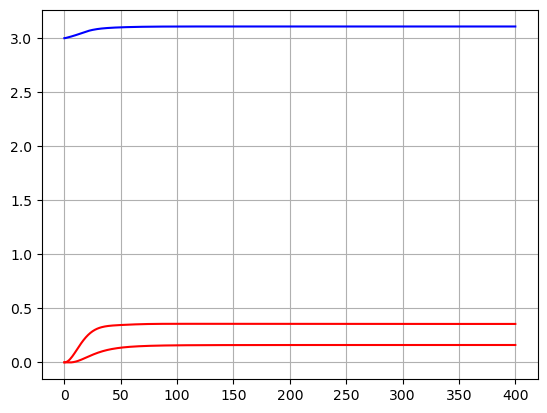

In [383]:
plt.plot(xhist[1,:],"red")
plt.plot(xhist[2,:],"red")
plt.plot(xhist[3,:],"blue")
plt.grid()

In [384]:
vis = Visualizer()
set_heli_model!(vis)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8752
└ @ MeshCat C:\Users\sdabir\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8752))

In [385]:
anim = animate(vis, xhist, thist, h)
setanimation!(vis, anim)




## Generate Wind

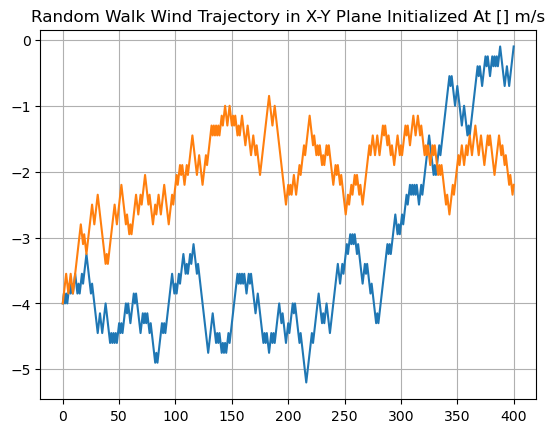

In [386]:
# Wind Vector Generation:

using Random

wind_vec = zeros(3, Nt)
wind_vec[:,1] .= [-4;-4;-1]#[40;40]
Random.seed!(1285);
for i = 1:Nt-1
    #wind_vec[:, i+1] .= wind_vec[:, i] .+ [rand((-10*h, 10*h)), rand((-10*h, 10*h)), rand((-10*h, 10*h))] 
    #wind_vec[1:2, i+1] .= zeros(2,1)

    wind_vec[:, i+1] .= wind_vec[:, i] .+ [rand((-3*h, 3*h)), rand((-3*h, 3*h)), rand((-3*h, 3*h))] # less aggressive
    #wind_vec[:, i+1] .= wind_vec[:, i] .+ [0.0, 0.0]
end

plt.plot(wind_vec[1, :]')
plt.plot(wind_vec[2,:]')
plt.title("Random Walk Wind Trajectory in X-Y Plane Initialized At [] m/s")
plt.grid()



## Hover + Wind (No DOb)

In [398]:
# Wind effects added
# Intialize Trajectory
uhist_lqr = zeros(Nu, Nt-1)
xhist_lqr = zeros(Nx, Nt)
xhist_lqr[:,1] = [0;0;0; [0; 1; 0; 0]; xhover[8:10]; xhover[11:13]; 0; 0; 0; 0; 0; 0]
#xhist[:,1] = [xhover[1:3] + [0;0;0]; [0; 1; 0; 0]; xhover[8:10]; xhover[11:13]; 0; 0; 0; 0; 0; 0]

# can't use the same K matrix here (it includes disturbance terms too...)
K2 = zeros(4,18)
K2 .= K
K2[:,13:end] .= zeros(4,6)

# Forward Rollout
for k = 1:(Nt-1)
    Δx̃ = state_error(xhist_lqr[:, k], xhover)
    uhist_lqr[:, k] = uhover - K2 * Δx̃ 
    xhist_lqr[14:16, k] .= [wind_vec[1, k]; wind_vec[2,k]; wind_vec[3,k]] #wind<<
    #xhist[14:16, k] .= [0; 0; 0]
    xhist_lqr[:, k+1] = helicopter_dynamics_RK4(xhist_lqr[:, k], uhist_lqr[:, k], h)
end
xhist

19×401 Matrix{Float64}:
  0.0          -0.0002547    -0.000795066  …   0.160262      0.160262
  0.0           0.000981658   0.00428652       0.355171      0.355171
  3.0           3.00118       3.00378          3.10803       3.10803
  0.0          -0.00305923   -0.00991508      -0.0665814    -0.0665814
  1.0           0.999994      0.999942         0.99776       0.99776
  0.0           0.00125913    0.00361574   …   0.00653006    0.00653003
  0.0           0.000727572   0.00234423      -0.000435778  -0.000435776
 -9.198e-24    -0.00992996   -0.0103566        8.94896e-7    8.74874e-7
 -7.32075e-24  -0.0390279    -0.0935229        1.16044e-6    1.13448e-6
  2.69966e-23  -0.0471736    -0.0548241        1.69153e-7    1.65375e-7
 -4.67112e-28   0.244723      0.303716     …   2.48681e-8    2.43117e-8
 -1.48226e-28   0.0581454     0.0713757        1.42686e-7    1.39493e-7
  2.81063e-28  -0.100798     -0.0877673        9.19758e-7    8.99184e-7
  0.0           0.0           0.0              0.0

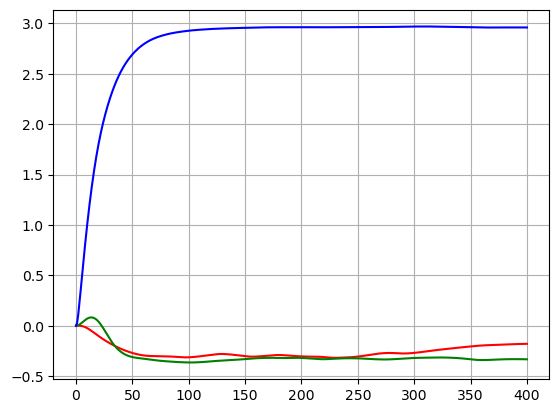

In [399]:
plt.plot(xhist_lqr[1,:],"red")
plt.plot(xhist_lqr[2,:],"green")
plt.plot(xhist_lqr[3,:],"blue")
plt.grid()

In [389]:
vis = Visualizer()
set_heli_model!(vis)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8753
└ @ MeshCat C:\Users\sdabir\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8753))

In [390]:
anim = animate(vis, xhist_lqr, thist, h)
setanimation!(vis, anim)

## Hover + Wind (DOb)

In [400]:
# Kalman Filtering:
H_kf = I(Nx);
P_kf = Diagonal([1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 10000.0, 100000.0, 10000.0, 10000.0, 10000.0, 100000.0])
Q_kf = Diagonal([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0])
R_kf = 0.01*Diagonal([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]);

# >>
#X_kf_init = [-1.0; 1.0; 0.0; 0.0; 1; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]
X_kf_init = [ [0;0;0]; [0; 1; 0; 0]; xhover[8:10]; xhover[11:13]; -1;1; 0; 0; 0; 0]
X_ref = xhover

U_kf = zeros(Nu, Nt-1)
X_kf = zeros(Nx, Nt)
X_kf[:, 1] .= X_kf_init

est_states1 = zeros(Nx, Nt)
est_states1[:,1] .= X_kf[:,1]

#Δx̃ = state_error(X_kf[:, 2], xhover)
#Δx̃ = state_error(xhist[:,3], xhover)
uhover

4-element Vector{Float64}:
   7.35426099766092e-26
   0.06857814048591515
  80.44199749635399
 -16.204902652988256

In [401]:
for k = 1:(Nt-1)
    #xhover = update_reference(est_states1[:,k+1],xhover)
    #Δx̃ = state_error(X_kf[:, k], xhover)
    Δx̃ = state_error(est_states1[:, k], xhover)
    #error[:,k] = Δx̃[13:15]
    
#     Q = qtoQ(est_states1[4:7])
#     w_b_est = Q'*est_states1[14:16]
#     Xfus = 0.5*ρ*Sx_fux*Cd*(est_states1[8] -w_b_est[1])*(est_states1[8] - w_b_est[1])
#     Yfus = 0.5*ρ*Sy_fux*Cd*(est_states1[9] - w_b_est[2])*(est_states1[9] - w_b_est[2])
#     Zfus = 0.5*ρ*Sz_fux*Cd*(est_states1[10] - w_b_est[3])*(est_states1[10] - w_b_est[3])
    U_kf[:, k] .= uhover - K * Δx̃ #+ Kff*est_states1[7:9,k]
    X_kf[14:16, k] .= [wind_vec[1, k]; wind_vec[2,k]; wind_vec[3,k]] #wind
    X_kf[:, k+1] .= helicopter_dynamics_RK4(X_kf[:, k], U_kf[:, k], h)
    X_kf[14:19,k+1] .= 0.0 # ensuring that wind at the previous time step is not correlated to next time step
    est_states1[:,k+1], P_kf = update_kf_trans(est_states1[:,k], U_kf[:, k], X_kf[:, k+1], H_kf, P_kf, Q_kf, R_kf)
    
    #euler[:,k] = qtoeul(X_kf[4:7,k])
 
end



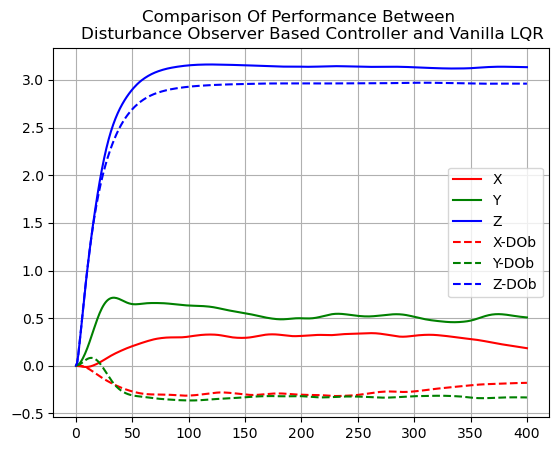

In [402]:
plt.plot(X_kf[1,:],"red")
plt.plot(X_kf[2,:],"green")
plt.plot(X_kf[3,:],"blue")

plt.plot(xhist_lqr[1,:],"r--")
plt.plot(xhist_lqr[2,:],"g--")
plt.plot(xhist_lqr[3,:],"b--")
plt.legend(["X","Y","Z","X-DOb","Y-DOb","Z-DOb"])
plt.title("Comparison Of Performance Between 
    Disturbance Observer Based Controller and Vanilla LQR")

plt.grid()


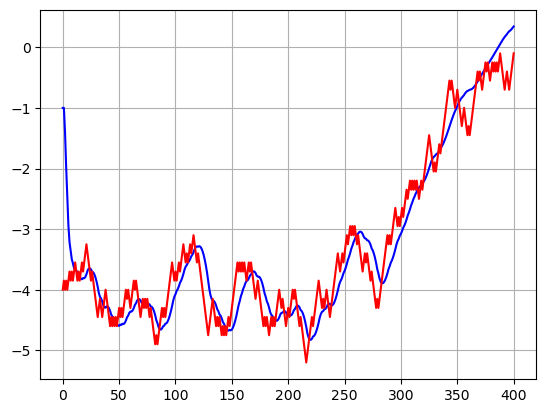

In [403]:
plt.plot(est_states1[14,:],"blue")
plt.plot(wind_vec[1,:],"red")
plt.grid()

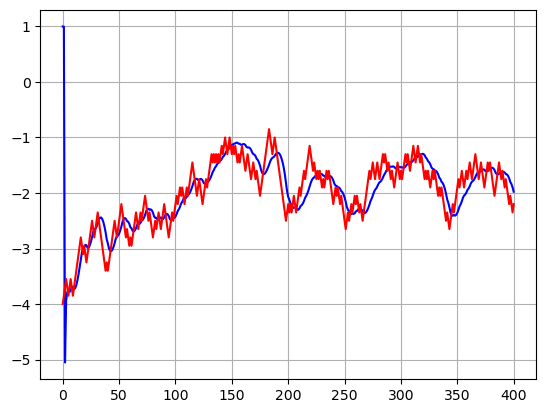

In [404]:
plt.plot(est_states1[15,:],"blue")
plt.plot(wind_vec[2,:],"red")
plt.grid()

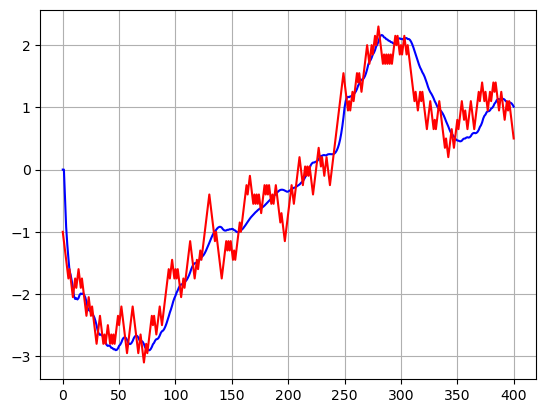

In [405]:
plt.plot(est_states1[16,:],"blue")
plt.plot(wind_vec[3,:],"red")
plt.grid()

In [397]:
vis = Visualizer()
set_heli_model!(vis)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8754
└ @ MeshCat C:\Users\sdabir\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8754))

In [344]:
# Hover without DOb
anim = animate(vis, xhist_lqr, thist, h)
setanimation!(vis, anim)

In [345]:
# Hover with DOb

anim2 = animate(vis, X_kf, thist, h)
setanimation!(vis, anim2)

## TODO: need to repeat DOb for straight line trajectory:

## Straight Line Trajectory:

In [36]:
# Straight Line Trajectory
using Random
ir, iq, iv, iw = state_parts()

X_str_init = [-0.1; 0.0; 10.0; 0.0; 1; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0; 0; 0; 0; 0; 0]; #add wind into the reference traj
X_str_final = xhover #add to final so interpolation keeps it constant
U_str_ref = zeros(Nu, Nt-1)
X_str_ref = zeros(Nx, Nt)

X_str_ref[:, 1] = X_str_init

dx_str = (X_str_final[ir] - X_str_init[ir]) / (Nt - 1)

for k = 1:Nt-1
    U_str_ref[:, k] = uhover
    X_str_ref[ir, k+1] = X_str_ref[ir, k] + dx_str
    dq_str = normalize(slerp(normalize(Quaternion(X_str_init[4], X_str_init[5:7])), normalize(Quaternion(X_str_final[4], X_str_final[5:7])), ((k-1)/(Nt-1))))
    X_str_ref[iq, k] = [dq_str.s; dq_str.v1; dq_str.v2; dq_str.v3]
    X_str_ref[iv, k] = (X_str_ref[ir, k+1] - X_str_ref[ir, k]) / h
    # Need to fix Angular Velocity
#     X_str_ref[iw, k] = [0;-pi/10;0]
end
X_str_ref[:, end] = X_str_final

# Tracking
U_str = zeros(Nu, Nt-1)
X_str = zeros(Nx, Nt)
X_str[:, 1] .= X_str_init

wind_vec = zeros(2, Nt)
wind_vec[:,1] .= [-15;-15]#[40;40]
Random.seed!(1234);
for i = 1:Nt-1
    wind_vec[:, i+1] .= wind_vec[:, i] .+ [rand((-5*h, 5*h)), rand((-5*h, 5*h))] 
    #wind_vec[:, i+1] .= wind_vec[:, i] .+ [0.0, 0.0]
end

H_kf = I(Nx);
P_kf = Diagonal([1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 10000.0, 100000.0, 10000.0, 10000.0, 10000.0, 100000.0])
Q_kf = Diagonal([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0])
R_kf = 0.01*Diagonal([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]);

est_states1 = zeros(Nx, Nt)
est_states1[:,1] .= X_str[:,1]

for k = 1:(Nt-1)
    #Δx̃ = state_error(X_str[:, k], X_str_ref[:, k])
    Δx̃ = state_error(est_states1[:, k], X_str_ref[:, k])
    U_str[:, k] .= U_str_ref[:, k] - K * Δx̃ 
    X_str[14:16, k] .= [wind_vec[1, k]; wind_vec[2,k]; 0] #wind
    X_str[:, k+1] .= helicopter_dynamics_RK4(X_str[:, k], U_str[:, k], h)
    X_str[14:19,k+1] .= 0.0 # ensuring that wind at the previous time step is not correlated to next time step
    est_states1[:,k+1], P_kf = update_kf_trans(est_states1[:,k], U_str[:, k], X_str[:, k+1], H_kf, P_kf, Q_kf, R_kf)
end
print(X_str_ref[:,1])

[-0.1, 0.0, 10.0, 0.0, 1.0, 0.0, 0.0, 0.0050000000000000044, 0.0, -0.3500000000000014, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [278]:
using Pkg
Pkg.add("Plots")
Pkg.add("PyPlot")

   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
   Installed VersionParsing ─ v1.3.0
   Installed PyPlot ───────── v2.10.0
   Installed Conda ────────── v1.7.0
   Installed PyCall ───────── v1.93.1
    Updating `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  [d330b81b] + PyPlot v2.10.0
    Updating `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
  [8f4d0f93] + Conda v1.7.0
  [438e738f] + PyCall v1.93.1
  [d330b81b] + PyPlot v2.10.0
  [81def892] + VersionParsing v1.3.0
    Building Conda ─→ `C:\Users\sdabir\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\6e47d11ea2776bc5627421d59cdcc1296c058071\build.log`
    Building PyCall → `C:\Users\sdabir\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\1fc929f47d7c151c839c5fc1375929766fb8edcc\build.

In [280]:
using Plots


In [268]:

plt.plot(X_str')
# Plots
#comparison_plot((X_str', U_str', thist, "LQR"))

LoadError: ArgumentError: Package matplotlib not found in current path:
- Run `import Pkg; Pkg.add("matplotlib")` to install the matplotlib package.


In [171]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8719))

In [172]:
anim_str =  animate(vis, X_str, thist,h) #animate(vis, est_states1, thist,h)
setanimation!(vis, anim_str)


In [264]:
anim_str =  animate(vis, est_states1, thist,h)
setanimation!(vis, anim_str)

In [308]:
X_str - est_states1 #

19×401 Matrix{Float64}:
   0.0    0.0            0.0          …   0.0           0.0
   0.0    0.0            0.0              0.0           0.0
   0.0    0.0            0.0              0.0           0.0
   0.0    0.0            0.0              0.0           0.0
   0.0    0.0            0.0              0.0           0.0
   0.0    0.0            0.0          …   0.0           0.0
   0.0    0.0            0.0              0.0           0.0
   0.0    0.0            0.0              0.0           0.0
   0.0    0.0            0.0              0.0           0.0
   0.0    0.0            0.0              0.0           0.0
   0.0    0.0            0.0          …   0.0           0.0
   0.0    0.0            0.0              0.0           0.0
   0.0    0.0            0.0              0.0           0.0
 -50.0  -49.4814       -11.3625          -0.311343     51.2669
   0.0   -0.5           -0.515536        -1.03911      -6.31793
   0.0    3.35853e-9     0.000354107  …   0.000289299   0.000310747
 

## MPC:

In [24]:
# MPC
using Random
# Build QP
function buildQP(Ã, B̃, Q, R, Qf, Nh, num_c)
    ñ,m = size(B̃)
    Np = (Nh-1)*(ñ+m)
    Nd = (Nh-1)*ñ
    P = spzeros(Np, Np)
    D = spzeros(Nd, Np)
    q = zeros(Np)
    #lb = zeros((Nh-1)*(ñ+4))
    #ub = zeros((Nh-1)*(ñ+4)) 
    lb = zeros((Nh-1)*(ñ+num_c))
    ub = zeros((Nh-1)*(ñ+num_c))
    
    P .= [kron(Diagonal(I,Nh-2),[R zeros(m,ñ); zeros(ñ,m) Q]) zeros((ñ+m)*(Nh-2), ñ+m); zeros(ñ+m,(ñ+m)*(Nh-2)) [R zeros(m,ñ); zeros(ñ,m) Qf]]
    D .= [[B̃ -I zeros(ñ,(Nh-2)*(m+ñ))]; zeros(ñ*(Nh-2),m) [kron(Diagonal(I,Nh-2), [Ã B̃]) zeros((Nh-2)*ñ,ñ)] + [zeros((Nh-2)*ñ,ñ) kron(Diagonal(I,Nh-2),[zeros(ñ,m) Diagonal(-I,ñ)])]]
    
    # Constraints
    #                             a b u u x y z ϕ θ ψ u v w p q r
    θ_c = kron(Diagonal(I, Nh-1), [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0])
    ϕ_c = kron(Diagonal(I, Nh-1), [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0])
    u1_c = kron(Diagonal(I, Nh-1), [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0])
    u2_c = kron(Diagonal(I, Nh-1), [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0])
    u3_c = kron(Diagonal(I, Nh-1), [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0])
    u4_c = kron(Diagonal(I, Nh-1), [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0])
#     p_c = kron(Diagonal(I, Nh-1), [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0])
#     q_c = kron(Diagonal(I, Nh-1), [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0])
    
    if num_c == 0
#         println("Constraints = 0")
        return P, D, q, lb, ub
    else
#         println("Constraints != 0")
#         return P, [D; u3_c; u4_c], q, lb, ub
#         return P, [D; u1_c; u2_c; u3_c; u4_c], q, lb, ub
#         return P, [D; u1_c; u2_c; u3_c; u4_c], q, lb, ub
        return P, [D; u1_c; u2_c; u3_c; u4_c; θ_c; ϕ_c], q, lb, ub
    end
    return
end
                
# Update QP
function update_QP(Ã, B̃, Q, R, Qf, Nh, Xref, Uref, x, N_t, num_c)
    ñ,m = size(B̃)
    
    Np = (Nh-1)*(ñ+m)
    Nd = (Nh-1)*ñ
    q = zeros(Np)
    #lb = zeros((Nh-1)*(ñ+4))
    #ub = zeros((Nh-1)*(ñ+4)) 
    lb = zeros((Nh-1)*(ñ+num_c))
    ub = zeros((Nh-1)*(ñ+num_c))
    
    uguess = Uref[:, end]
    xguess = Xref[:, end]
    xguess[14:16] .= x[14:16] #update wind estimate
    xhover, uhover = get_trim(xguess, uguess) #solve for equilibrium
    
    xeq = xhover
    ueq = uhover
    
    rpeq = qtorp(xeq[4:7])
#     xeq = xhover
#     ueq = uhover
    
    for i = 1:(Nh-1)
        index = N_t + i
        if (index > size(Xref, 2))
            index = size(Xref, 2)
        end
        q[(i*(m+ñ)-ñ+1):i*(m+ñ)] .= -Q * state_error(Xref[:, index], xeq)
        if (i == (Nh-1))
            q[(i*(m+ñ)-ñ+1):i*(m+ñ)] .= -Qf * state_error(Xref[:, index], xeq)            
        end
    end    
#     Constraints
    # Discrete Jacobian
    A = ForwardDiff.jacobian(x->helicopter_dynamics_RK4(x, ueq, h), xeq)
    B = ForwardDiff.jacobian(u->helicopter_dynamics_RK4(xeq, u, h), ueq)

    Ã = state_error_jacobian(xeq)' * A * state_error_jacobian(xeq)
    
    #D = [[B̃ -I zeros(ñ,(Nh-2)*(m+ñ))]; zeros(ñ*(Nh-2),m) [kron(Diagonal(I,Nh-2), [Ã B̃]) zeros((Nh-2)*ñ,ñ)] + [zeros((Nh-2)*ñ,ñ) kron(Diagonal(I,Nh-2),[zeros(ñ,m) Diagonal(-I,ñ)])]]
    
    lb[1:ñ] = -Ã * state_error(x, xeq)
    ub[1:ñ] = -Ã * state_error(x, xeq)
    
    if num_c != 0
    #     u1_c
        lb[Nd+0*(Nh-1)+1:Nd+1*(Nh-1)] .= -0.15 - ueq[1]
        ub[Nd+0*(Nh-1)+1:Nd+1*(Nh-1)] .= 0.15 - ueq[1]

    #     u2_c
        lb[Nd+1*(Nh-1)+1:Nd+2*(Nh-1)] .= -0.15 - ueq[2]
        ub[Nd+1*(Nh-1)+1:Nd+2*(Nh-1)] .= 0.15 - ueq[2]
        
    #     u3_c
        lb[Nd+2*(Nh-1)+1:Nd+3*(Nh-1)] .= 0 - ueq[3]
        ub[Nd+2*(Nh-1)+1:Nd+3*(Nh-1)] .= 2.5 * M * g - ueq[3]

    #     u4_c
        lb[Nd+3*(Nh-1)+1:Nd+4*(Nh-1)] .= -M * g / ntr - ueq[4]
        ub[Nd+3*(Nh-1)+1:Nd+4*(Nh-1)] .= M * g / ntr - ueq[4]

        # Roll Constraints
        lb[Nd+4*(Nh-1)+1:Nd+5*(Nh-1)] .= -Inf #-20*pi/180 - atan(2*(xeq[4]*xeq[5] - xeq[6]*xeq[7]), (1-2*(xeq[5]^2+xeq[6]^2)))
        ub[Nd+4*(Nh-1)+1:Nd+5*(Nh-1)] .= Inf #20*pi/180 - atan(2*(xeq[4]*xeq[5] - xeq[6]*xeq[7]), (1-2*(xeq[5]^2+xeq[6]^2)))

        # Pitch Constraints
        lb[Nd+5*(Nh-1)+1:Nd+6*(Nh-1)] .= -Inf #-20*pi/180 - asin(2*(xeq[4]*xeq[6] - xeq[7]*xeq[5]))
        ub[Nd+5*(Nh-1)+1:Nd+6*(Nh-1)] .= Inf #20*pi/180 - asin(2*(xeq[4]*xeq[6] - xeq[7]*xeq[5]))

        #up_c - doesn't work, vehicle starts shifting to the side?
        #lb[Nd+2*(Nt-1)+1:Nd+3*(Nh-1)] .= -0.75
        #ub[Nd+2*(Nt-1)+1:Nd+3*(Nh-1)] .= 0.75

        #uq_c
        #lb[Nd+3*(Nt-1)+1:Nd+4*(Nh-1)] .= -0.75
        #ub[Nd+3*(Nt-1)+1:Nd+4*(Nh-1)] .= 0.75
    end
    
    return q, lb, ub
end

# Solve MPC
function solve_mpc(con, hor)
    # Setting Trajectory
    U_str_mpc = zeros(Nu, Nt-1)
    X_str_mpc = zeros(Nx, Nt)
    X_str_mpc[:, 1] .= X_str_init
    
    # Setting Solver
    prob = OSQP.Model()
    P_prob, A_prob, q_prob, lb_prob, ub_prob = buildQP(Ã, B̃, Q, R, Qf, hor, con)
    OSQP.setup!(prob; P=P_prob, q=q_prob, A=A_prob, l=lb_prob, u=ub_prob, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1)
    
    H_kf = I(Nx);
    P_kf = Diagonal([1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 10000.0, 100000.0, 10000.0, 10000.0, 10000.0, 100000.0])
    Q_kf = Diagonal([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0])
    R_kf = 0.01*Diagonal([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]);

    # Rollout
    est_states = zeros(Nx, Nt)
    est_states[:,1] .= X_str_mpc[:,1]
    wind_vec = zeros(2, Nt)
    wind_vec[:,1] .= [1000; 1000]
    Random.seed!(1234);
    for i = 1:Nt-1
        wind_vec[:, i+1] .= wind_vec[:, i] .+ [rand((-10*h, 10*h)), rand((-10*h, 10*h))] 
    end
    for k = 1:(Nt-1)
        X_str_mpc[14:19, k] = est_states[14:19,k] #update estimate
        q_prob, lb_prob, ub_prob = update_QP(Ã, B̃, Q, R, Qf, hor, X_str_ref, U_str_ref, X_str_mpc[:, k], k, con)
        OSQP.update!(prob, q=q_prob, l=lb_prob, u=ub_prob)
        results = OSQP.solve!(prob)
        Δu = results.x[1:Nu]
        U_str_mpc[:, k] .= U_str_ref[:, k] + Δu 
        X_str_mpc[14:16, k] = [wind_vec[1,k]; wind_vec[2,k]; 0] #add in random wind here
        X_str_mpc[:, k+1] .= helicopter_dynamics_RK4(X_str_mpc[:, k], U_str_mpc[:, k], h)
        X_str_mpc[14:19, k+1] .= 0.0
        est_states[:,k+1], P_kf = update_kf_trans(est_states[:,k], U_str_mpc[:,k], X_str_mpc[:,k+1], H_kf, P_kf, Q_kf, R_kf)
    end
    
    return X_str_mpc, U_str_mpc, est_states
end

solve_mpc (generic function with 1 method)

In [25]:
X_str_mpc1, U_str_mpc1 = solve_mpc(0, 51);

ERROR in osqp_update_bounds: lower bound must be lower than or equal to upper bound


LoadError: Error updating bounds l and u

In [26]:
rmse_mpc = 0
for k = 1:(Nt-1)
    rmse_mpc += norm(X_str_ref[1:13,k] - X_str_mpc1[1:13,k])^2
end
rmse_mpc = sqrt(rmse_mpc/ Nt) 

rmse_lqr = 0
for k = 1:(Nt-1)
    rmse_lqr += norm(X_str_ref[1:13,k] - X_str[1:13,k])^2
end
rmse_lqr = sqrt(rmse_lqr/ Nt) 
println(rmse_mpc)
print(rmse_lqr)

LoadError: UndefVarError: X_str_mpc1 not defined

In [27]:
# Plots
comparison_plot((X_str', U_str', thist, "LQR"), (X_str_mpc1', U_str_mpc1', thist, "MPC"))

LoadError: UndefVarError: X_str_mpc1 not defined

In [28]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [29]:
anim_str_mpc1 = animate(vis, X_str_mpc1, thist, h)
setanimation!(vis, anim_str_mpc1)

LoadError: UndefVarError: X_str_mpc1 not defined

In [30]:
X_str_mpc2, U_str_mpc2 = solve_mpc(6, 51);

LoadError: DimensionMismatch("All inputs to vcat should have the same number of columns")

In [31]:
# Plots
comparison_plot((X_str', U_str', thist, "LQR"), (X_str_mpc2', U_str_mpc1', thist, "MPC"))

LoadError: UndefVarError: X_str_mpc2 not defined

In [32]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [73]:
anim_str_mpc2 = animate(vis, X_str_mpc2, thist)
setanimation!(vis, anim_str_mpc2)

LoadError: UndefVarError: X_str_mpc2 not defined

In [ ]:
# Run with a bunch of horizons
horizons = [21,31,41,51,61,71,81,91,101]

Z = map(horizons) do horizon
    # Constrained MPC
    println("Running with horizon: $horizon")
    Xmpc, Umpc = solve_mpc(6, horizon)
    (Xmpc', Umpc', thist,"N = " * string(horizon))
end;

In [ ]:
comparison_plot(Z...)